# Settlement Calculations of Embankments

<div class="alert alert-warning" role="alert">
  Input grond informations. User needs to manully type the information of each layer into the "layer" section below. Each pair of "{...}" stores the information of one layer. The layer information should be input sequentially from top to bottom. User can remove or add layers as needed by deleting or adding "{...}". Then click "Cell -> Run all" to run the whole pipline of the program. 
</div>

In [40]:
import json

ground_info = {
  "ground_elevation": 10,
  "slope_a": 15,
  "surcharge_elevation": 7,
  "surcharge_weight": 120,
  "ground_water_depth": 10.4,
  "layers": [
    {"soil_type":"SM \nML \nSC \nML", "thickness": 10.4, 
     "effective_unit_weight": 120, "CR": 0.01, "RR": 5e-4, "OCR": 1.5},
    
    {"soil_type":"SP", "thickness": 1.6, 
     "effective_unit_weight": 57.6, "CR": 0.01, "RR": 5e-4, "OCR": 1},
    
    {"soil_type":"SP", "thickness": 2.5, 
     "effective_unit_weight": 57.6, "CR": 0.01, "RR": 5e-4, "OCR": 1},
    
    {"soil_type":"ML", "thickness": 5, 
     "effective_unit_weight": 56.6, "CR": 0.16, "RR": 0.041, "OCR": 1},
    
    {"soil_type":"SP-SM", "thickness": 5, 
     "effective_unit_weight": 57.6, "CR": 0.01, "RR": 5e-4, "OCR": 1},
    
    {"soil_type":"ML \nML \nMH", "thickness": 15, 
     "effective_unit_weight": 57.6, "CR": 0.16, "RR": 0.041, "OCR": 1},
    
    {"soil_type":"SP", "thickness": 20, 
     "effective_unit_weight": 56.6, "CR": 0.01, "RR": 5e-4, "OCR": 1},
    
    {"soil_type":"ML", "thickness": 15, 
     "effective_unit_weight": 56.6, "CR": 0.16, "RR": 0.041, "OCR": 1},
    
    {"soil_type":"CL \nSM \nCH", "thickness": 26, 
     "effective_unit_weight": 67.6, "CR": 0.001, "RR": 1e-4, "OCR": 1},
    
    {"soil_type":"SM \nSP", "thickness": 9, 
     "effective_unit_weight": 67.6, "CR": 0.001, "RR": 1e-4, "OCR": 1}
            ]
          }

with open('ground_info.json', 'w') as outfile:
    json.dump(ground_info , outfile)

All the supporting functions are archived in this section. User can click the "+" button to review the calculating procedures. In most cases, user does not need to modify this seciton. 

This calculation based on the available laboratory consolidation data at HA-213 site. Fill height = 5 ft, fill unit weight
= 120 pcf. The Over Consolidation Ratio (OCR) is assuemed to be 1 in the calculation. But the Python code provided
in this section is able to solve the primary consolidation when the OCR > 1 base on the equation 8-13, 8-17, and 8-19
in the “AN INTRODUCTION TO GEOTECHNICAL ENGINEERING,” BY R.D. HOLTZ & W.D. KOVACS.
As shown in the figure, the calculation result is directly plotted on the Haley&Aldrich template. The height of the
plot of each soil layer is scaled according to the ratio of the soil layer thickness to the total calculation depth. And the
teoretical ground surface settlement curve is plotted on the right side to help engineers avoid uneven settlement.

In [41]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math
import json
from hapy.plotting import HCFigure
import os
import sys
import datetime as datetime
import numpy as np

def surcharge_plot(asdf, plot_range, ground_data):
    """
    Create surcharge plot and add to HA figure template
    input: matplotlib axes (the whole range for the plot)
    returns: surcharges
    """
    # axis for the surcharge plot
    # groundAx = asdf.addPlotAxes([plot_range[0]/8.5, (10.5-2.5)/11,
    #                             (plot_range[2]/2-0.05)/8.5, 2.45/11])
    groundAx = asdf.addPlotAxes([(plot_range[2]/2+0.05 + plot_range[0])/8.5, (10.5-2.5)/11,
                                 (plot_range[2]/2)/8.5, 2.45/11])
    
    groundAx.get_xaxis().set_visible(False)
    groundAx.get_yaxis().set_visible(False)
    
    groundAx.set_axis_off()
    logo = os.path.join(os.path.dirname('file'),'images','surcharge_pic.png')
    logoimg = mpl.image.imread(logo)
    groundAx.imshow(logoimg, interpolation='none')
    
    # adding measures to the plot
    groundAx.text(120, 0.5, 'a = ' + str(ground_data["slope_a"]) + ' ft', fontsize=10)
    groundAx.text(380, 20, 'Elev. ' + str(ground_data["ground_elevation"])  + ' ft', fontsize=10)
    groundAx.text(320, 135, 'H = ' + str(ground_data["surcharge_elevation"]) + ' ft' + "\n" + 
                             '$\gamma$ = ' + str(ground_data["surcharge_weight"]) + ' pcf', fontsize=10)

    return groundAx

def deform_plot(asdf, plot_range, ground_data, layer_num):
    """
    Create ground deformation plot and add to HA figure template
    input: matplotlib axes (the whole range for the plot)
    returns: ground deformation plot
    """
    # axis for the deformation plot
    # deformAx = asdf.addPlotAxes([(plot_range[2]/2+0.05 + plot_range[0])/8.5, (10.5-2.5)/11,
    #                              (plot_range[2]/2)/8.5, 2.45/11])
    deformAx = asdf.addPlotAxes([(plot_range[2]/2+0.48 + plot_range[0])/8.5, (10.5-5+0.2)/11,
                                 (plot_range[2]/2-0.5)/8.5, 2.25/11])

    ax = deformAx
    ax.set_xlabel('Horizontal location X (ft)')
    ax.set_ylabel('Total settlement (ft)', labelpad=-3)
    
    deform_store = []
    for point_x in range(0, 200):    
        cal_sum =[]
        for layer_n in range(0, layer_num):
            # print(layer_calculaton(asdf, plot_range, ground_data, layer_n, point_x))
            cal_sum.append(layer_calculaton(asdf, plot_range, ground_data, layer_n, point_x))
    
        eps_total = 0
        for layer_n in range(0, layer_num):
            eps_total += cal_sum[layer_n][9]
        
        deform_store.append([point_x, -eps_total])

    ax.plot(np.array(deform_store)[:,0], np.array(deform_store)[:,1])

    return ax

def layer_calculaton(asdf, plot_range, ground_data, layer_num, point_x):
    """
    Calculate and plot results for each layer
    input: ground_data for calculation, layer_num to locate layers, 
           plot_range to generate axies, point_x for the x of cal. point
    returns: layer calculation result. 
    """
    
    # find calculation depth
    if layer_num == 0:
        z = ground_data["layers"][0]["thickness"]/2  # the middle of the first layer
    else:
        z = 0
        for n in range(0, layer_num):
            z = z + ground_data["layers"][n]["thickness"]
        z = z + ground_data["layers"][layer_num]["thickness"]/2
            
    # find alpha, beta, and lambda
    if point_x > 0:
        lamb = np.arctan(z/point_x)
    elif point_x == 0:
        lamb = math.pi/2
    elif point_x < 0:
        lamb = math.pi - np.arctan(z/abs(point_x))
    
    slope_a = ground_data["slope_a"]
    if point_x > slope_a:
        bta = math.pi - np.arctan(z / (point_x-slope_a))
    elif point_x == slope_a:
        bta = math.pi/2
    elif point_x < slope_a:
        bta = np.arctan(z / (slope_a-point_x))
        
    alp = math.pi - lamb - bta
    
    sig_z = ground_data["surcharge_elevation"] * ground_data["surcharge_weight"] * \
    (ground_data["slope_a"]*bta + point_x*alp)/(math.pi * slope_a)
    d_p = sig_z
    
    # find cumulative original ground pressure (self weight)
    if layer_num == 0:
        sig_v = ground_data["layers"][0]["thickness"]/2 * \
                ground_data["layers"][0]["effective_unit_weight"] # the middle of the first layer
    else:
        sig_v = 0
        for n in range(0, layer_num):
            sig_v = sig_v + ground_data["layers"][n]["thickness"] * \
                            ground_data["layers"][n]["effective_unit_weight"] 
        sig_v = sig_v + ground_data["layers"][layer_num]["thickness"]/2 * \
                    ground_data["layers"][layer_num]["effective_unit_weight"] 
    
    # calculated layer deformaton eps_c 
    # 8-13 NC clay, 8-17 OC clay when sig_v + d_p <= sig_p, 8-19 
    sig_p = sig_v * ground_data["layers"][layer_num]["OCR"]
    ai = sig_z/(ground_data["surcharge_elevation"] * ground_data["surcharge_weight"])            
    
    OCR = ground_data["layers"][layer_num]["OCR"]
    if OCR <= 1:
        eps_c = ground_data["layers"][layer_num]["thickness"] * \
            ground_data["layers"][layer_num]["CR"] * math.log10((sig_z+sig_v)/sig_v)
        # print(ground_data["layers"][layer_num]["CR"])
    elif OCR > 1 and (sig_z+sig_v) <= sig_p:
        eps_c = ground_data["layers"][layer_num]["thickness"] * \
            ground_data["layers"][layer_num]["RR"] * math.log10((sig_z+sig_v)/sig_v)
    elif OCR > 1 and (sig_z+sig_v) > sig_p:
        eps_c = ground_data["layers"][layer_num]["thickness"] * \
            ground_data["layers"][layer_num]["RR"] * math.log10(sig_p/sig_v) + \
            ground_data["layers"][layer_num]["thickness"] * ground_data["layers"][layer_num]["CR"] * \
            math.log10((sig_z+sig_v)/sig_p)       
    
    return [z, alp, bta, lamb, sig_z, d_p, sig_v, sig_p, ai, eps_c] 
    
def layer_plot(asdf, plot_range, ground_data, cal_sum, layer_n, layer_num):
    # total depth of ground for scalled plot
    total_h = 0
    for n in range(0, layer_num):
        total_h += ground_data["layers"][n]["thickness"]
    
    # find the bottom (y_0) of new layer plot 
    sec_t = 0 # the thickness of all ploted blocks (including the current one)
    for n in range(0, layer_n+1):
        sec_t += ground_data["layers"][n]["thickness"]/total_h * plot_range[3]
    sec_bottom = plot_range[1] + plot_range[3] - sec_t   
 
    # the height of the current lyaer plot    
    sec_h = ground_data["layers"][layer_n]["thickness"]/total_h * plot_range[3]
      
    # the width of each layer of soil plot
    sec_w = plot_range[2]/2 - 0.05    
    
    layerAx = asdf.addPlotAxes([plot_range[0]/8.5,  sec_bottom/11, 
                                sec_w/8.5, sec_h/11]) 
    layerAx.get_xaxis().set_visible(False)
    layerAx.get_yaxis().set_visible(False)
    
    layerAx.text(0.1, 0.5, 'Hi = '+str(ground_data["layers"][layer_n]["thickness"])+' ft', va='center', ha='center', fontsize=8)
    
    soilAx = asdf.addPlotAxes([(plot_range[0]+0.8)/8.5,  sec_bottom/11, 
                                0.5/8.5, sec_h/11]) 
    soilAx.get_xaxis().set_visible(False)
    soilAx.get_yaxis().set_visible(False)
    soilAx.set_axis_off    
    
    if 'M' in ground_data["layers"][layer_n]["soil_type"]:
        soilAx.bar(1, 2, edgecolor='blue', color='white', hatch='...')
    elif 'S' in ground_data["layers"][layer_n]["soil_type"]:
        soilAx.bar(1, 2, edgecolor='blue', color='white', hatch='xx')    
    elif 'G' in ground_data["layers"][layer_n]["soil_type"]:
        soilAx.bar(1, 2, edgecolor='blue', color='white', hatch='OO')      
    soilAx.text(1.1, 1, str(ground_data["layers"][layer_n]["soil_type"]), va='center', ha='center')    
    
    # print intermediate results
    layerAx.text(0.7, 0.4, '$\epsilon_c$  = '+str(round(cal_sum[layer_n][9],2))+' ft'+'\n',
                    va='center', ha='center', fontsize=8)
        
    soilAx.set_xlim([1,1])
    soilAx.set_ylim([0,2])
    return layerAx, soilAx



C:\Users\hehez\AppData\Local\Temp/ipykernel_19436/3815256890.py:188: UserWarning: Attempting to set identical left == right == 1 results in singular transformations; automatically expanding.
  soilAx.set_xlim([1,1])


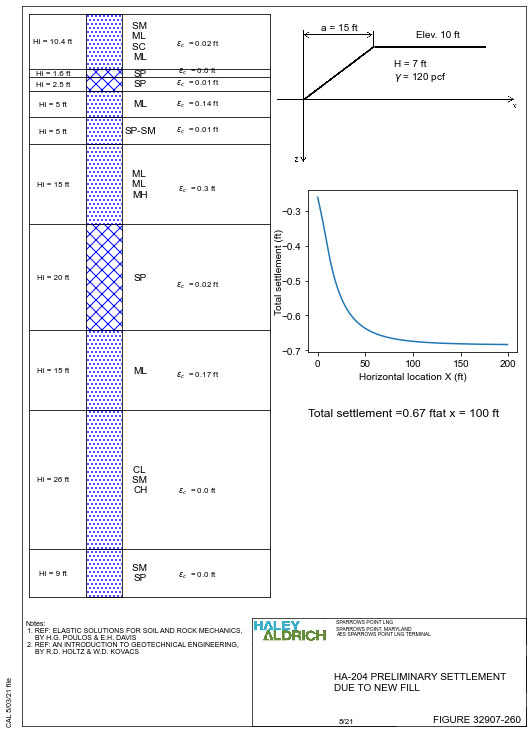

In [62]:

# type the notes and title here:
add_note = [
            "REF: ELASTIC SOLUTIONS FOR SOIL AND ROCK MECHANICS, BY H.G. POULOS & E.H. DAVIS",
             "REF: AN INTRODUCTION TO GEOTECHNICAL ENGINEERING, BY R.D. HOLTZ & W.D. KOVACS"
            ]

long_title = "HA-204 PRELIMINARY SETTLEMENT \nDUE TO NEW FILL"

if __name__ == '__main__':
    # add lorem ipsum notes
    # print(__file__)
    asdf = HCFigure(style = 'ha',
                  title=long_title,
                  author='Cal',
                  date=datetime.datetime.now(),
                  filename='file',
                  size=[8.5, 11],
                  orientation='p',
                  city='Sparrows Point',
                  state='Maryland',
                  sitename='aes Sparrows point Lng Terminal',
                  prjnum='XXXX-XX',
                  prjname='Sparrows Point LNG',
                  fignum='32907-260',
                  note=add_note
                  )
    
    with open("ground_info.json", "r") as read_file:
        ground_data = json.load(read_file)
        
    plot_range = [1.1, 2.3, 6.8, 8.1] # x, y of the lower left corner, dx, dy
    surcharge_plot(asdf, plot_range, ground_data)
    
    layer_num = len(ground_data["layers"])
    point_x = 100
    
    cal_sum =[]
    for layer_n in range(0, layer_num):
        # print(layer_calculaton(asdf, plot_range, ground_data, layer_n, point_x))
        cal_sum.append(layer_calculaton(asdf, plot_range, ground_data, layer_n, point_x))
    
    eps_total = 0
    for layer_n in range(0, layer_num):
        eps_total += cal_sum[layer_n][9]
        layer_plot(asdf, plot_range, ground_data, cal_sum, layer_n, layer_num)
    # print(cal_sum[9][:])
    deform_plot(asdf, plot_range, ground_data, layer_num)
    
    
    # plot the tables of total settlement at base of footing
    totalsettleAx = asdf.addPlotAxes([0.6, 0.25, 0.3, 0.2])
    totalsettleAx.axis('tight')
    totalsettleAx.axis('off')
    # totalsettleAx.set_title('Total Settlement at Calculation Point')
    totalsettleAx.text(-0.06, 0.05, 'Total settlement =' + str(round(eps_total,2)) + ' ft' + 'at x = ' + str(point_x) + ' ft', 
                       ha='left', va='center', fontsize=12)
    

    asdf.add_text()
    asdf.saveHCFigure("embankment_settle.pdf")